**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to improve and see how you stack up to others taking this course.

The steps in this notebook are:
1. Build a Random Forest model with all of your data (**X** and **y**).
2. Read in the "test" data, which doesn't include values for the target.  Predict home values in the test data with your Random Forest model.
3. Submit those predictions to the competition and see your score.
4. Optionally, come back to see if you can improve your model by adding features or changing your model. Then you can resubmit to see how that stacks up on the competition leaderboard.

## Recap
Here's the code you've written so far. Start by running it again.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

In [2]:
def load_data():
    df_train = pd.read_csv('../input/train.csv', index_col='Id')
    df_test = pd.read_csv('../input/test.csv', index_col='Id')
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [3]:
def clean(df):
    #MSSubClass should be converted to type object since it represents categorical data
    df["MSSubClass"] = df["MSSubClass"].astype(str)
    
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    #df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    
    rating_features = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", 
                       "BsmtCond", "HeatingQC", "KitchenQual",
                   "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
    
    # Convert ratings based on their descriptions 
    replacement_dict = {"Above_Average": 6, "Average": 5, "Below_Average": 4, "Excellent":9, "Fair":3,
       "Good": 7, "Poor": 2, "Very_Excellent": 10, "Very_Good": 8, "Very_Poor": 1}
    df.replace({"OverallQual": replacement_dict},inplace=True)
    df.replace({"OverallCond": replacement_dict},inplace=True)
    
    #YearBuilt must always be lower or equal to year remodelled 
    df.loc[1877, "YearRemodAdd"] = df.loc[1877, "YearBuilt"]
    
    #To correct YrSold values to YearRemodAdd
    df.loc[524, "YrSold"] = df.loc[524,"YearRemodAdd"]
    df.loc[2296, "YrSold"] = df.loc[2296,"YearRemodAdd"]
    df.loc[2550, "YrSold"] = df.loc[2550,"YearRemodAdd"]
    
    #If MasVnrType is None, then MasVnrArea is 0
    check = df[(df["MasVnrType"]=="None") & (df["MasVnrArea"]!=0)]
    df.loc[check.index, "MasVnrArea"] = 0
    
    #some basement features are actual missing values, most of them just mean there is no basement, 
    #which is not a missing value
    basement_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", 
                         "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]
    #Actual missing values
    basement_missing = df[basement_features].isna()
    basement_missing["basement_missing"] = basement_missing.sum(axis=1)
    basement_missing = basement_missing[(basement_missing["basement_missing"] > 0) & 
                                    (basement_missing["basement_missing"] < 5)]
    
    #Fill the categorical missing values where there is a basement
    #Basement exposure is assumed to indicate the presence of a basement and 
    #missing values assumed to equal no basement
    df["BsmtExposure"].fillna("No_basement", inplace=True) 
    df.loc[2218, "BsmtQual"] = df["BsmtQual"].mode()[0]    
    df.loc[2219, "BsmtQual"] = df["BsmtQual"].mode()[0]
    df.loc[2041, "BsmtCond"] = df["BsmtCond"].mode()[0]
    df.loc[2186, "BsmtCond"] = df["BsmtCond"].mode()[0]
    df.loc[2525, "BsmtCond"] = df["BsmtCond"].mode()[0]
    df.loc[333, "BsmtFinType2"] = df["BsmtFinType2"].mode()[0]
    
    #all other missing categorical values are assumed to have no basement 
    df["BsmtQual"].fillna("No_basement", inplace=True)
    df["BsmtFinType1"].fillna("No_basement", inplace=True)
    df["BsmtFinType2"].fillna("No_basement", inplace=True)
    df["BsmtCond"].fillna("No_basement", inplace=True)
    
    #Fill numerical missing values
    df["BsmtFinSF1"].fillna(0, inplace=True)
    df["BsmtFinSF2"].fillna(0, inplace=True)
    df["BsmtUnfSF"].fillna(0, inplace=True)
    df["TotalBsmtSF"].fillna(0, inplace=True)
    df["BsmtFullBath"].fillna(0, inplace=True)
    
    #Fill actual missing numerical values with mode and categorical with no basement 
    bsmnt_fill_mode = df.loc[basement_missing.index][["BsmtExposure", "BsmtFinType1"]].replace("No_basement", 
                            df[["BsmtExposure", "BsmtFinType1"]].mode().T[0])
    df.update(bsmnt_fill_mode)
    
    #some garage features are actual missing values, most of them just mean there is no garage, 
    #which is not a missing value
    garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", 
                       "GarageCond"]
    
    #Actual missing values 
    garage_missing = df[garage_features].isna()
    garage_missing["garage_missing"] = garage_missing.sum(axis=1)
    garage_missing = garage_missing[(garage_missing["garage_missing"] > 0) & 
                                    (garage_missing["garage_missing"] < 5)]
    
    #Fill categorical missing values where there is no basement
    df["GarageType"].fillna("No_garage", inplace=True)
    df["GarageFinish"].fillna("No_garage", inplace=True)
    df["GarageQual"].fillna("No_garage", inplace=True)
    df["GarageCond"].fillna("No_garage", inplace=True)
    
    #Fill numerical missing values
    df["GarageYrBlt"].fillna(0, inplace=True)
    df["GarageArea"].fillna(0, inplace=True)
    df["GarageCars"].fillna(0, inplace=True)
    
    #Fill missing values with mode
    garage_fill_mode = df.loc[garage_missing.index]["GarageFinish"].replace("No_garage", 
                                    df["GarageFinish"].mode().T[0])
    df.update(garage_fill_mode)
    
    #Fill categorical missing values where there is no fireplace
    df["FireplaceQu"].fillna("No_fireplace", inplace=True)
    
    #Fill categorical missing values where there is a pool
    df.loc[2421, "PoolQC"] = df["PoolQC"].mode()[0]
    df.loc[2504, "PoolQC"] = df["PoolQC"].mode()[0]
    df.loc[2600, "PoolQC"] = df["PoolQC"].mode()[0]
    
    #Fill categorical missing values where there is no pool
    df["PoolQC"].fillna("No_Pool", inplace=True)
    
    #Fill the missing value in Kitchen Quality
    df.loc[1556, "KitchenQual"] = df["KitchenQual"].mode()[0]
    
    #To convert ratings to numeric values using the scale in OverallQual
    rating_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
                   "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
    replacement_dict_2 = {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1, 
                      "No_fireplace": 0, "No_garage": 0, "No_basement": 0, "No_Pool": 0}
    for col in rating_features:
        df[col] = df[col].map(replacement_dict_2)
    
    #To check YearBuilt and GarageYrBuilt are the same, for houses with a garage 
    date_features = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"]
    check_2 = df[(df["YearBuilt"] > df["GarageYrBlt"]) & (df["GarageYrBlt"] != 0)][date_features]
    df.loc[check_2.index, "GarageYrBlt"] = check_2["YearBuilt"] 
    
   
    return df

In [4]:
def impute(df):
    categorical_columns = []
    numeric_columns = []
    for c in df.columns:
        if df[c].map(type).eq(str).any(): #check if there are any strings in column
            categorical_columns.append(c)
        else:
            numeric_columns.append(c)
                
    #create two DataFrames, one for each data type
    data_numeric = df[numeric_columns]
    data_categorical = pd.DataFrame(df[categorical_columns])
    
    for col in data_numeric.select_dtypes(include=np.number):
        data_numeric[col] = data_numeric[col].fillna(data_numeric[col].mode()[0])
        
    for name in data_categorical:
        data_categorical[name] = data_categorical[name].fillna("None")
        
    #join the two masked dataframes back together
    df = pd.concat([data_numeric, data_categorical], axis = 1) 
    return  df 

In [5]:
def score_dataset(X, y, model=XGBRegressor(n_estimators=1000, learning_rate=0.05)):
    # Label encoding for categoricals
    label_encoder = LabelEncoder()
    object_cols = [col for col in X.columns if X[col].dtype == "object"]
    for col in object_cols: 
        X[col] = label_encoder.fit_transform(X[col])
     # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [6]:
#We can reuse this scoring function anytime we want to try out a new feature set. 
#We'll run it now on the processed data with no additional features and get a baseline score:

df_train,df_test = load_data()
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Baseline score: 0.13025 RMSLE


In [7]:
def make_mi_scores(X, y):
    X = X.copy()
    label_encoder = LabelEncoder()
    object_cols = [col for col in X.columns if X[col].dtype == "object"]
    for col in object_cols: 
        X[col] = label_encoder.fit_transform(X[col])
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

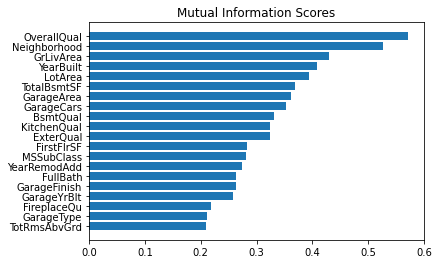

In [8]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)

#print(mi_scores.head(20))
#print(mi_scores.tail(5))  # uncomment to see bottom 20

#plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
#plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [9]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [10]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.12862250654832544

In [11]:
def mathematical_transforms(df): #not good
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    
    return X


def interactions(df): #good
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df): # not good
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df): #not good
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df): #good
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

def group_transforms_2(df): #good
    X = pd.DataFrame()
    X["MeanNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("mean")
    return X

def group_transforms_3(df): #good
    X = pd.DataFrame()
    X["StdNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("std")
    return X

def group_transforms_4(df): #good
    X = pd.DataFrame()
    X["CntNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("count")
    return X

def mathematical_transforms_2(df): #good
    X = pd.DataFrame()
    X["OverallQualCond"] = df.OverallQual * df.OverallCond
    return X

"""take the square roots of area features, this would convert units of square feet to just feet
take the logarithms of numeric features, If a feature has a skewed distribution, applying a logarithm can 
help normalise it since the square root function can also be used to normalise, it has to be ensured that
any no area features are normalised twice"""

def sqrt_area_features(df): #good
    area_features = ["LotArea", "LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "FirstFlrSF", "SecondFlrSF", "LowQualFinSF", "GrLivArea",
                      "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "Threeseasonporch", "ScreenPorch", "PoolArea"]
    X = pd.DataFrame()
    X["Skewness"] = df.select_dtypes(include=np.number).skew(axis = 0)
    global features_to_normalise
    features_to_normalise = list(X[X["Skewness"].abs()>0.5].T) #features with abs skewness greater than 0.5
    area_features_dont_need_norm = [x for x in area_features if x not in features_to_normalise]
    for col in area_features_dont_need_norm: 
        df[col] = np.sqrt(df[col])
        return df

def fixing_skewness(df): #not good
    for col in features_to_normalise:
        df[col] = np.log1p(df[col])
        return df 

In [12]:
cluster_features = [ #not good
    "LotArea",
    "OverallQual",
    "GrLivArea",
    "YearBuilt",
    "GrLivArea",
] #features picked based on high M.I. scores

def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [13]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [14]:
df_train.corrwith(df_train.SalePrice).nlargest(11)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
ExterQual      0.682639
KitchenQual    0.659600
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
FirstFlrSF     0.605852
BsmtQual       0.604816
FullBath       0.560664
dtype: float64

In [15]:
#features highly correlated with the target feature 
features = [
    "OverallQual",
    "GrLivArea",
    "ExterQual",
    "KitchenQual",
    "GarageCars",
    "GarageArea",
    "TotalBsmtSF",
]

In [16]:
X = df_train.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                  PC1       PC2       PC3       PC4       PC5       PC6  \
OverallQual  0.418385 -0.245483  0.011097 -0.137113 -0.466295 -0.719178   
GrLivArea    0.334344 -0.013410  0.629985 -0.643817  0.162245  0.223495   
ExterQual    0.389947 -0.404559 -0.288890  0.039317 -0.437236  0.638652   
KitchenQual  0.377713 -0.399101 -0.355102 -0.001550  0.744087 -0.134156   
GarageCars   0.394973  0.534591 -0.236118 -0.035382 -0.046755 -0.022810   
GarageArea   0.390671  0.572295 -0.155572  0.060988  0.064426  0.077898   
TotalBsmtSF  0.331384 -0.057443  0.559899  0.748452  0.071189  0.019247   

                  PC7  
OverallQual  0.105454  
GrLivArea   -0.019499  
ExterQual    0.014789  
KitchenQual -0.016994  
GarageCars  -0.706044  
GarageArea   0.694056  
TotalBsmtSF -0.088200  


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

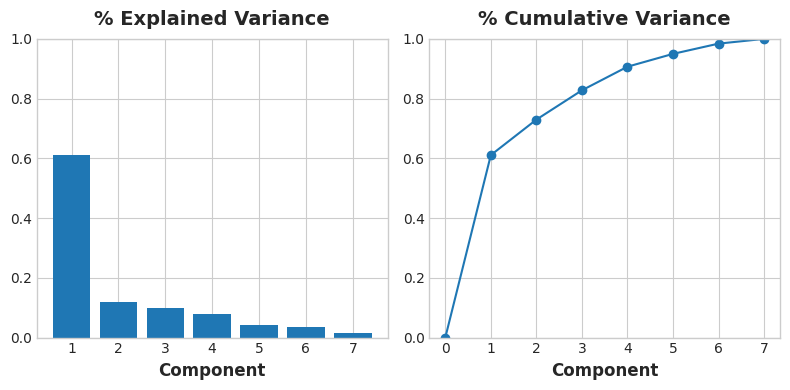

In [17]:
plot_variance(pca)

In [18]:
def pca_inspired(df): #good
    X = pd.DataFrame()
    X["Feature1"] = df.GarageCars / df.GarageArea
    X["Feature2"] = df.OverallQual + df.GrLivArea
    X["Feature3"] = df.GrLivArea + df.TotalBsmtSF
    return X

def pca_components(df, features): #not good
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

In [19]:
# You can change PC1 to PC2, PC3, PC4 or PC5
component = "PC5"

idx = X_pca[component].sort_values(ascending=False).index
df_train[["SalePrice", "Neighborhood", "SaleCondition"] + features].reindex(idx)

,SalePrice,Neighborhood,SaleCondition,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF
1173,171900.0,Somerst,Normal,7.0,1250.0,7.0,7.0,2.0,625.0,625.0
607,152000.0,CollgCr,Normal,5.0,1040.0,5.0,7.0,2.0,576.0,1040.0
588,137000.0,Sawyer,Normal,5.0,860.0,5.0,5.0,2.0,528.0,840.0
630,168500.0,NAmes,Normal,6.0,1350.0,5.0,5.0,2.0,520.0,1248.0
129,155000.0,NAmes,Normal,6.0,1348.0,5.0,5.0,2.0,453.0,660.0
...,...,...,...,...,...,...,...,...,...,...
586,369900.0,Timber,Partial,8.0,2028.0,7.0,7.0,3.0,880.0,1868.0
1211,189000.0,SawyerW,Normal,6.0,1845.0,7.0,7.0,2.0,462.0,1055.0
919,238000.0,SawyerW,Normal,7.0,2127.0,7.0,7.0,3.0,833.0,1104.0
1147,180000.0,SawyerW,Normal,6.0,1298.0,7.0,7.0,2.0,403.0,1298.0


In [20]:
def label_encode(df):
    X = df.copy()
    label_encoder = LabelEncoder()
    object_cols = [col for col in X.columns if X[col].dtype == "object"]
    for col in object_cols: 
        X[col] = label_encoder.fit_transform(X[col])
    return X

In [21]:
#to determine which features to target encode 
df_train.select_dtypes(["object"]).nunique()>7

MSSubClass        True
MSZoning         False
Street           False
Alley            False
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood      True
Condition1        True
Condition2        True
BldgType         False
HouseStyle        True
RoofStyle        False
RoofMatl          True
Exterior1st       True
Exterior2nd       True
MasVnrType       False
Foundation       False
BsmtExposure     False
BsmtFinType1     False
BsmtFinType2     False
Heating          False
CentralAir       False
Electrical       False
Functional       False
GarageType       False
GarageFinish     False
PavedDrive       False
Fence            False
MiscFeature      False
SaleType          True
SaleCondition    False
dtype: bool

In [22]:
#features for target encoding 
cols = ["Neighborhood", "SaleType", "Exterior1st", "Exterior2nd","Condition1", "Condition2", "HouseStyle", 
       "RoofMatl", "MSSubClass"]

In [23]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [24]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(interactions(X))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))
    X = X.join(group_transforms_2(X))
    X = X.join(group_transforms_3(X))
    X = X.join(group_transforms_4(X))
    X = X.join(mathematical_transforms_2(X))
    X = sqrt_area_features(X)

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=cols), how = 'left', lsuffix = '_left', rsuffix = '_right')
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test), how = 'left', lsuffix = '_left', rsuffix = '_right')

    if df_test is not None:
        return X, X_test
    else:
        return X

# Creating a Model For the Competition

Build a Random Forest model and train it on all of **X** and **y**.

In [25]:
#to optimise the XGBRregressor model 

"""import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params"""

'import optuna\n\ndef objective(trial):\n    xgb_params = dict(\n        max_depth=trial.suggest_int("max_depth", 2, 10),\n        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),\n        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),\n        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),\n        subsample=trial.suggest_float("subsample", 0.2, 1.0),\n        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),\n        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),\n    )\n    xgb = XGBRegressor(**xgb_params)\n    return score_dataset(X_train, y_train, xgb)\n\nstudy = optuna.create_study(direction="minimize")\nstudy.optimize(objective, n_trials=20)\nxgb_params = study.best_params'

In [26]:
#optimised model parameters 

xgb_params = dict(
    max_depth=9, 
    learning_rate= 0.0026912099970591713, 
    n_estimators= 4770, 
    min_child_weight= 8, 
    colsample_bytree= 0.2110727162304385, 
    subsample= 0.3613877422815094, 
    reg_alpha= 0.0003326889524248118, 
    reg_lambda= 0.0009645240649349676,
)

In [27]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]
xgb = XGBRegressor(**xgb_params)

score_dataset(X_train, y_train, xgb)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.11775164483573299

# Make Predictions
Read the file of "test" data. And apply your model to make predictions

In [28]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Your submission was successfully saved!


Before submitting, run a check to make sure your `test_preds` have the right format.

In [29]:
# Check your answer
step_1.check()
#step_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#ccaa33">Check:</span> When you've updated the starter code, `check()` will tell you whether your code is correct. Remember, you must create the following variable: `test_preds`

# Test Your Work

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on [this link](https://www.kaggle.com/c/home-data-for-ml-course).  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continuing Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  Look at the list of columns and think about what might affect home prices.  Some features will cause errors because of issues like missing values or non-numeric data types. 

The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.


# Other Courses
The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161285) to chat with other Learners.*